# Polynomial regression 

The example belows uses a temperature-energy dataset in order to illustrate how to perform a non linear regression.

Workflow:
1. Preparation
    - Extract the dataset from the _power_demand_vs_temperature.csv_ 
    - Explore the dataset and check for missing values
    - Plot the distribution
    - Divide the dataset into train and test 
    - Create an evaluation function
2. First experiment
    - Create a linear model 
    - Train the model on X_train and y_train
    - Evaluate the model on X_test and y_test
    - Visualize the prediction of the model
3. Second experiment
    - Create a polynomial regression model with degree 2
    - Train the model on X_train and y_train
    - Evaluate the model on X_test and y_test
    - Visualize the prediction of the model
4. Third experiment
    - repeat the steps done in the second experiment but with degree 3
5. Third experiment
    - repeat the steps done in the second experiment but with degree 4
6. Compare the evaluation of each model


In [10]:
# Code source: Filippo Orazi 
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

random_state = 42 # this will be used to guarantee the repeatability of the experiment
ts = 0.3

## Dataset preparation

### Load the dataset from a `.csv` file

Set the date column as index

In [3]:
url = "power_demand_vs_temperature.csv"

df = pd.read_csv(url)
df = df.set_index("date")
df.head()

,demand,temp
date,,
2015-01-01,1.736065,1.7
2015-01-02,1.831672,2.2
2015-01-03,1.714934,14.4
2015-01-04,1.628577,15.6
2015-01-05,2.045394,0.0


### Explore the dataset and check for missing values


In [4]:
df.describe()

,demand,temp
count,1096.000000,1096.000000
mean,1.831796,16.927737
std,0.329434,10.791581
min,1.316033,-15.000000
25%,1.581654,8.900000
50%,1.731479,18.900000
75%,2.024869,26.100000
max,2.804025,33.900000


In [5]:
print(f"The dataframe has {df.isnull().any(axis=1).sum()} invalid rows")

The dataframe has 0 invalid rows


### Create X and y 

In [7]:
target = "demand"

X = df.drop(target, axis=1)
y = df[target]
print(X.shape, y.shape)

(1096, 1) (1096,)


### Plot the distribution



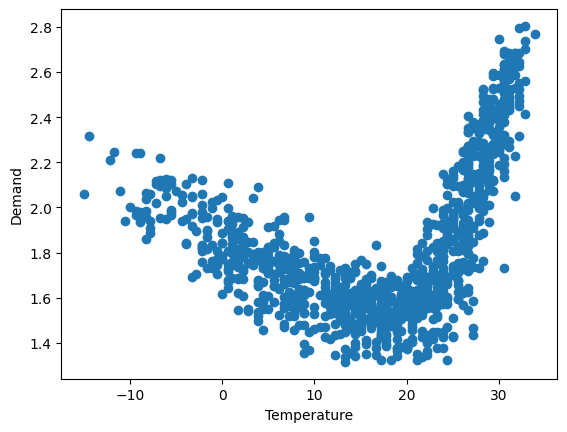

In [8]:
plt.scatter(X, y)
plt.xlabel("Temperature")
plt.ylabel("Demand")
plt.show()

### Divide the dataset in train and test splits

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=random_state)
print(f"Training set and test set have {X_train.shape[0]} and {X_test.shape[0]} elements respectively")

Training set and test set have 767 and 329 elements respectively


### Sort the test set

In [13]:
X_test_sorted_indexes = X_test.sort_values(by="temp").index
X_test = X_test.loc[X_test_sorted_indexes]
y_test = y_test.loc[X_test_sorted_indexes]

### Create an evaluation function to compute, print and return the metrics: rmse r2 f-statistic and p-value

In [14]:
# Computation of F-statistic and p-value for the regression
# http://facweb.cs.depaul.edu/sjost/csc423/documents/f-test-reg.htm

def f_test(y_true, y_pred, n_var, n_obs):
    """ Computation of F-statistic and p-value for the regression
    Arguments:
    y_true: ground truth
    y_pred: predictions
    n_var: number of predicting variables
    n_obs: number of observations (the length of y_true and y_pred)

    Returns:
    F: F statistics
    p: p-value
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n = n_obs
    p = n_var+1 # number of regression parameters (coefficients + intercept)
    y_true_m = np.mean(y_true)
    SSM = np.sum((y_pred-y_true_m)**2)
    SST = np.sum((y_true-y_true_m)**2)
    SSE = np.sum((y_true-y_pred)**2)
    DFT = n - 1
    DFM = p - 1 # degrees of freedom for model - numerator
    DFE = n - p # degrees of freedom for error - denominator
    DFT = n - 1
    MSM = SSM / DFM
    MSE = SSE / DFE
    MST = SST / DFT
    F = MSM / MSE
    # f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic
    p = 1-scipy.stats.f.cdf(F, DFM, DFE) #find p-value of F test statistic
    return F, p

def print_eval(X, y, model):
    """ Predicts for X given a fitted model and
        prints prediction quality with respect to y
    Requires f_test (returning F and p-value), mean_squared_error, r2_score

    Arguments:
    X : array-like predicting data
    y : ground truth
    model: predictor fitted model

    Return: MSE, r2_score, F, p-value
    """
    pred = model.predict(X)
    F, p = f_test(y, pred, X.shape[1], X.shape[0])
    print(" Mean squared error: \t{:.5}".format(mean_squared_error(y,pred)))
    print(" r2 score: \t\t{:.5}".format(r2_score(y,pred)))
    print(" f-statistic: \t\t{:.5}".format(F))
    print(" p-value: \t\t{:.5}".format(p))
    return mean_squared_error(pred, y), r2_score(y,pred), F, p


## First experiment
Create a linear model 

Train the model on X_train and y_train 

Evaluate the model on X_test and y_test


In [16]:
lin_reg = LinearRegression().fit(X_train, y_train)
lin_reg_eval = print_eval(X_test, y_test, lin_reg)

 Mean squared error: 	0.10165
 r2 score: 		0.16809
 f-statistic: 		44.576
 p-value: 		1.0503e-10


#### Visualize the prediction of the model 

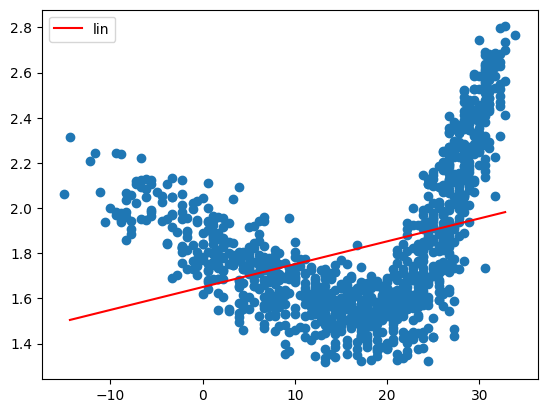

In [20]:
y_pred_lin = lin_reg.predict(X_test)

plt.scatter(X, y)
plt.plot(X_test, y_pred_lin, label="lin", c="r")
plt.legend()
plt.show()

## Second experiment - Polynomial regression
We can clearly see that the linear regression model cannot really approximate the data distribution.

We can now try with a non linear regression model:
1. Use the sklearn fucntion _PolynomialFeature_ to create a new array of features. Set _degree=2_ and _include_bias=False_
2. Train a Linear regression model with the new features
3. Evaluate the model 
4. Visualize the predicted values of the model

#### Polynomial degree = 2

In [24]:
poly_deg2 = PolynomialFeatures(degree=2, include_bias=False)
X_train_deg2, X_test_deg2 = poly_deg2.fit_transform(X_train, y_train), poly_deg2.transform(X_test)

lin_reg_deg2 = LinearRegression().fit(X_train_deg2, y_train)

In [27]:
lin_reg_deg2_eval = print_eval(X_test_deg2, y_test, lin_reg_deg2)

 Mean squared error: 	0.033456
 r2 score: 		0.72619
 f-statistic: 		384.89
 p-value: 		1.1102e-16


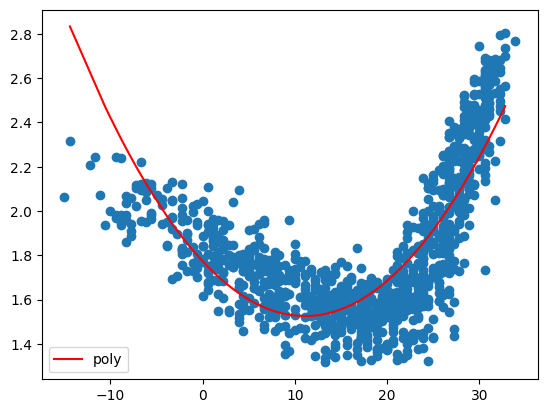

In [28]:
y_pred_deg2 = lin_reg_deg2.predict(X_test_deg2)
plt.scatter(X, y)
plt.plot(X_test, y_pred_deg2, label="poly", c="r")
plt.legend()
plt.show()

## Third experiment

#### Polynomial degree = 3

In [29]:
poly_deg3 = PolynomialFeatures(degree=3, include_bias=False)
X_train_deg3, X_test_deg3 = poly_deg3.fit_transform(X_train, y_train), poly_deg3.transform(X_test)

lin_reg_deg3 = LinearRegression().fit(X_train_deg3, y_train)

In [30]:
lin_reg_deg3_eval = print_eval(X_test_deg3, y_test, lin_reg_deg3)

 Mean squared error: 	0.021749
 r2 score: 		0.822
 f-statistic: 		502.32
 p-value: 		1.1102e-16


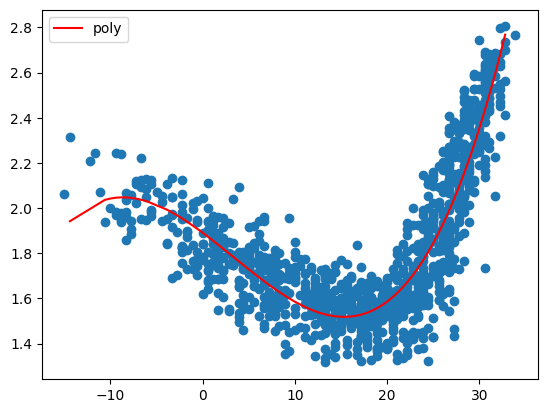

In [32]:
y_pred_deg3 = lin_reg_deg3.predict(X_test_deg3)

plt.scatter(X, y)
plt.plot(X_test, y_pred_deg3, label="poly", c="r")
plt.legend()
plt.show()

## Fourth experiment
### Polynomial degree = 4

In [33]:
poly_deg4 = PolynomialFeatures(degree=4, include_bias=False)
X_train_deg4, X_test_deg4 = poly_deg4.fit_transform(X_train, y_train), poly_deg4.transform(X_test)

lin_reg_deg4 = LinearRegression().fit(X_train_deg4, y_train)

In [34]:
lin_reg_deg4_eval = print_eval(X_test_deg4, y_test, lin_reg_deg4)

 Mean squared error: 	0.021334
 r2 score: 		0.8254
 f-statistic: 		390.05
 p-value: 		1.1102e-16


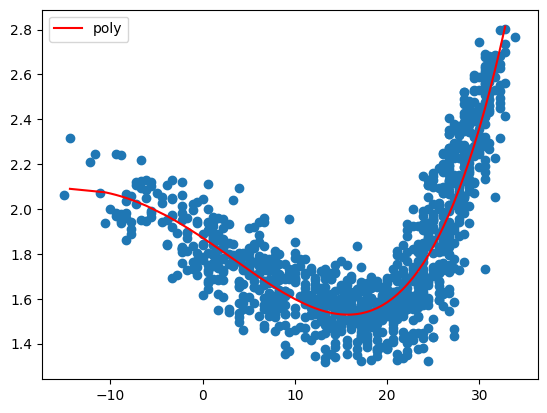

In [35]:
y_pred_deg4 = lin_reg_deg4.predict(X_test_deg4)

plt.scatter(X, y)
plt.plot(X_test, y_pred_deg4, label="poly", c="r")
plt.legend()
plt.show()